In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
import import_ipynb
from util import utils

# 环境

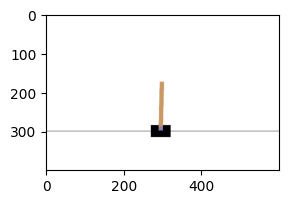

In [3]:
env = utils.CartPoleEnv(max_step=200, failure_score=-1000)
# env = CartPoleEnv()
state = env.reset(seed=0)
env.show()

# 算法定义

## Qnet

In [16]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        # x: (batch_size, state_dim)变为(batch_size, hidden_dim)
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        # (batch_size, action_dim)
        return self.fc2(x)

## VAnet

In [6]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q

## DQN类

In [7]:
class DQN:
    ''' DQN算法，包括DQN，DoubleDQN和DuelingDQN '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_frequency, device, name='DQN'):
        self.action_dim = action_dim
        if name == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            # Q网络
            self.q_net = VAnet(state_dim, hidden_dim,
                              action_dim).to(device)  
            # 目标网络
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                     action_dim).to(device)
        else:
            # Q网络
            self.q_net = Qnet(state_dim, hidden_dim,
                              action_dim).to(device)  
            # 目标网络
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_frequency = target_frequency  # 目标网络更新频率
        self.update_count = 0  # 计数器，记录更新次数
        self.device = device
        self.name = name
        self.max_q_value_list = []
        self.max_q_value = 0

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            # argmax无参数时返回所有元素中最大值的下标
            action = self.q_net(state).argmax().item()
        return action

    def get_max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']),
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']),
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # Q值，(batch_size)
        q_values = self.q_net(states).gather(1, actions)  
        # 下个状态的最大Q值
        if self.name == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones
                                                                )  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()
        self.update_count += 1
        # 更新目标网络
        if self.update_count % self.target_frequency == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  

    def play(self, env, update=False, show=False, replay_buffer=None):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            self.max_q_value = self.get_max_q_value(
                        state) * 0.005 + self.max_q_value * 0.995  # 平滑处理
            self.max_q_value_list.append(self.max_q_value)  # 保存每个状态的最大Q值
            action = agent.take_action(state)
            next_state, reward, done = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_return += reward
            if show:
                display.clear_output(wait=True)
                env.show()
            if update:
                # 当 buffer数据的数量超过一定值后，才更新网络
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
        return episode_return   

# 初始化

In [8]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [9]:
buffer_size = 10000
batch_size = 64
minimal_size = 500
replay_buffer = utils.ReplayBuffer(buffer_size)

In [10]:
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n
lr = 2e-3
gamma = 0.98
epsilon = 0.01
# 目标网络更新频率
target_frequency = 10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
name = 'DQN'
# name = 'DoubleDQN'
# name = 'DuelingDQN'
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_frequency, device, name=name)

In [11]:
num_episodes = 500
epochs = 10

# 玩一局游戏（训练前）

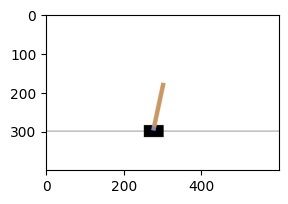

回报：-991.0


In [13]:
episode_return = agent.play(env, update=False, show=True, replay_buffer=replay_buffer)
print("回报：{}".format(episode_return))

# 算法训练

## 训练过程

In [14]:
def train(env, agent, num_episodes, epochs, replay_buffer=None):
    return_list = [] # 记录每一条序列的回报
    update = True
    show = False
    for i in range(epochs): # 显示epochs个进度条
        with tqdm(total=int(num_episodes / epochs), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / epochs)):  # 每个进度条的序列数
                episode_return = agent.play(env, update, show, replay_buffer)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [15]:
return_list = train(env=env, agent=agent, num_episodes=num_episodes, epochs=epochs, replay_buffer=replay_buffer)

Iteration 9: 100%|████████████████████████████████████████| 50/50 [01:28<00:00,  1.77s/it, episode=500, return=200.000]


## 训练结果

### 训练回报

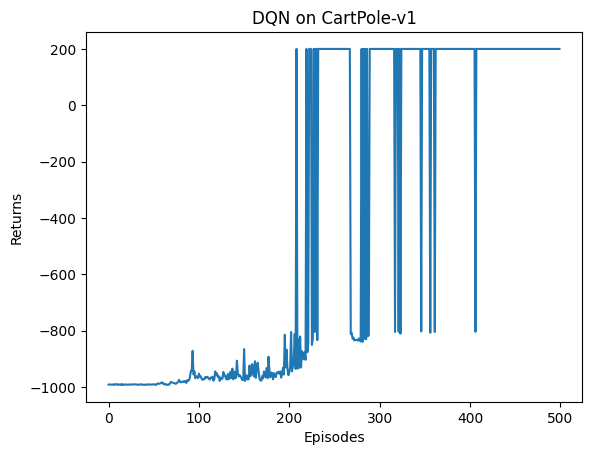

In [17]:
utils.show_return(return_list, agent, env)

### 移动平均训练回报

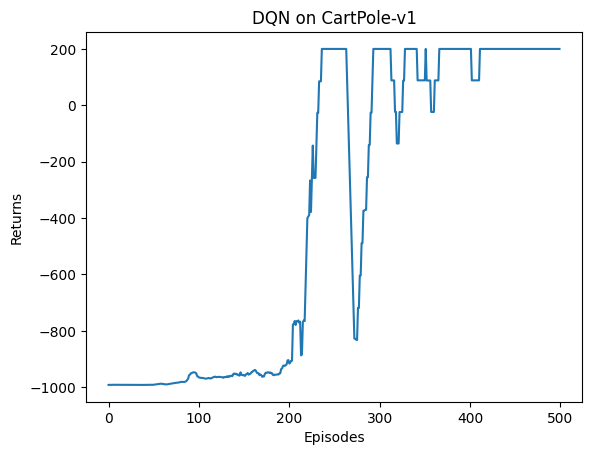

In [18]:
mv_return = utils.moving_average(return_list, 9)
utils.show_return(mv_return, agent, env)

# 再玩一局游戏（训练后）

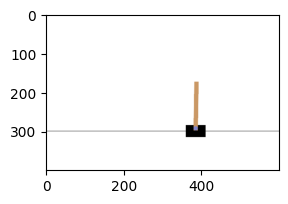

回报：200.0


In [19]:
episode_return = agent.play(env, update=False, show=True, replay_buffer=replay_buffer)
print("回报：{}".format(episode_return))